# Capacitated Facility Location Problem
\begin{align*}
\text{minimize} \quad & \sum_{j=1}^{n} f_j y_j + \sum_{i=1}^{m} \sum_{j=1}^{n} c_{ij} x_{ij} \\
\text{subject to}  \quad & \sum_{j=1}^{n} x_{ij} = D_i  & (i = 1, 2, \dots, m) \\
& \sum_{i=1}^{n} x_{ij} \leq K_j . y_j  & j = 1, 2, \dots, n \\
& y_j \in \{0,1\} &  j = 1, 2, \dots, n \\
&x_{ij}  \in \mathbf{R}^+  & i = 1, 2, \dots, m, j = 1, 2, \dots, n
\end{align*}

### Parameters

- $f_j$ is the setup cost of facility $j$,
- $c_{ij}$ is the transportation cost (distance) of serving demand $i$ from facility $j$,
- $D_i$ is the demand at node $i$,
- $K_j$ is the capacity of facility $j$,


### Decision Variables
- $x_{ij}$ is the amount of demand from customer $i$  that is serviced by facility $j$

- $y_j =  
\begin{cases}
    1,& \text{if facility} \ j \ \text{is open} \\
    0,              & \text{otherwise}
\end{cases}$

import gurobipy as gp
from gurobipy import  Model, GRB, quicksum
import numpy as np
import time
import math
import matplotlib.pyplot as plt

In [2]:
rnd = np.random
rnd.seed(89)

Specify the number of customers and the number of facilities

In [3]:
m = 1000 # number of demand points (customers)
n = 4 # number of facilities


Generate lists for demand and facilities

In [4]:
Demand = [i for i in range(1, m + 1)]
Facility = [j for j in range(1, n + 1)]

Locate customers and facilities on a map

In [5]:
x_F = [ rnd.randint(0, 100) for j in Facility ]
y_F = [ rnd.randint(0, 100) for j in Facility ]

In [6]:
x_D = [ rnd.randint(0, 100) for i in Demand ]
y_D = [ rnd.randint(0, 100) for i in Demand ]

Plot customers and facilities on the map

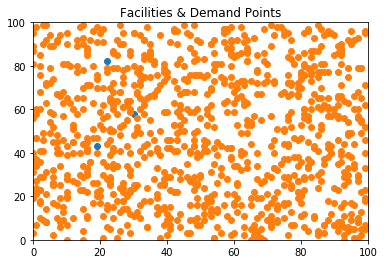

In [7]:
plt.xlim(0,100)
plt.ylim(0,100)
plt.scatter(x_F, y_F)
plt.scatter(x_D, y_D)
plt.title('Facilities & Demand Points')
plt.show()

Generate the fixed cost and capacity of the facilities

In [8]:
fixed_cost = {j : rnd.randint(100, 500) for j in Facility}

In [9]:
Capacity = {j : rnd.randint(1000, 5000) for j in Facility}

Generate the demand for each customer

In [10]:
D = {j : rnd.randint(1, 5) for j in Demand}

We can write a function to calculate the distance between two nodes

In [11]:
 def Calculate_distance(x_F , y_F , x_D ,y_D):
    return math.sqrt( (x_F - x_D)**2 + (y_F - y_D)**2 )

Create a disctionary to store all the distances:

In [12]:
c = { (i,j) : Calculate_distance( x_F[j-1] , y_F[j-1] , x_D[i-1] , y_D[i-1] ) for j in Facility for i in Demand }

Declaring the model

In [13]:
model = gp.Model('CFLP')

GurobiError: License expired 2023-10-25

Adding the decision variables

In [ ]:
x = model.addVars(c.keys() , vtype = GRB.CONTINUOUS, name = 'x')

In [ ]:
y = model.addVars(Facility , vtype = GRB.BINARY, name = 'y' )

Adding the constraint: each demand has to be satisfied

In [ ]:
Demand_c = model.addConstrs( (gp.quicksum( x[i,j] for j in Facility ) == D[i] for i in Demand), name="Demand")

Adding the constraint: Assignment is not possible unless the facility is open

In [ ]:
Facility_c = model.addConstrs( gp.quicksum( x[i,j] for i in Demand ) <= Capacity[j] * y[j] for j in Facility )

Sometimes, we can add constraints to cut our solution space. This helps the solver to solve the model faster. 
In general, these constraints are called **Valid Inequalities** 

In [ ]:
#model.addConstrs( x[i,j] <= D[i] * y[j] for j in Facility for i in Demand )

Specify the objective function

In [ ]:
model.setObjective( gp.quicksum( c[i,j] * x[i,j] for i in Demand for j in Facility ) 
               + gp.quicksum( fixed_cost[j] * y[j] for j in Facility ) , GRB.MINIMIZE )

Update and write the model

In [ ]:
model.update()
model.write('CFLP.lp')

Solve the model

In [ ]:
start = time.time()
model.optimize()
end = time.time()

In [22]:
def print_solution(model):
    if model.status != GRB.OPTIMAL:
        print("Model is not Optimized")
    
    else:
        print('Objective function value: ', model.objVal)
        print('Solution time: ', end - start, ' seconds')
        print('=================================================')
        vars = model.getVars()
        values = model.getAttr('x', vars)
        for var, val in zip(vars, values):
            if val > 1e-6:
                print(f"{var.varName}: {val}") 

In [14]:
print_solution(model)

NameError: name 'print_solution' is not defined

Let us use visualization to better undrestand the solution.

No. of Demands that are served by Facility 1 :  220
No. of Demands that are served by Facility 2 :  476
No. of Demands that are served by Facility 3 :  113
No. of Demands that are served by Facility 4 :  191


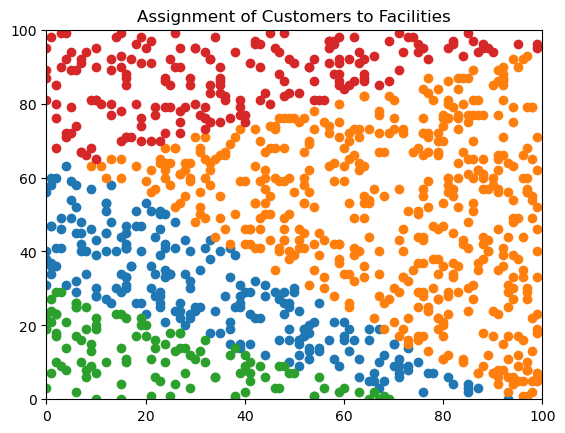

In [24]:
plt.xlim(0,100)
plt.ylim(0,100)
plt.title('Assignment of Customers to Facilities')

selected_facilities = [ j for j in Facility if y[j].x > 0.5 ]

for k in range(len(selected_facilities)):
    j = selected_facilities[k]
    served_by_k = [ i for i in Demand if x[i,j].x > 0.5 ]
    x_S = [ x_D[j-1] for j in served_by_k ]
    y_S = [ y_D[j-1] for j in served_by_k ]
    plt.scatter(x_S, y_S)
    print("No. of Demands that are served by Facility",j,": ",len(served_by_k))
